# 处理数据

In [1]:
import json
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

### 读数据

In [3]:
jsonl_df = pd.read_json('chexbert_labels/report_fixed.json', lines=True)
csv_df = pd.read_csv('df_chexpert_plus_240401.csv')
merged_df = pd.merge(jsonl_df, csv_df, on='path_to_image')   # 以path_to_image结合
print(f"json的长度：{len(jsonl_df)}")
print(f"csv的长度：{len(csv_df)}")
print(f"merge后的长度：{len(merged_df)}")

json的长度：223462
csv的长度：223462
merge后的长度：223462


### 处理掉 findings 为空且长度小于2的数据

In [4]:
merged_df = merged_df[merged_df['section_findings'].apply(lambda x: isinstance(x, str) and len(x.split()) >= 2)]

In [5]:
with open("radgraph-XL-annotations/section_findings.json") as f:
    annotations = json.load(f)

In [6]:
index = 4
findings = merged_df.iloc[index]["section_findings"]
annotation = annotations[index]
print(findings)
print(annotation['0']['text'])

# 两者一样

 Persistent small bilateral pleural effusions. The left
effusion is slightly greater when compared to the prior exam.
Lungs are clear. Stable cardiomediastinal silhouette .
Calcifications are again seen in the right suprahilar region, which
may represent calcified lymph nodes or post surgical change. Bones
are stable with mild degenerative changes of the spine. Sternotomy
wires are unchanged.

Persistent small bilateral pleural effusions . The left effusion is slightly greater when compared to the prior exam . Lungs are clear . Stable cardiomediastinal silhouette . Calcifications are again seen in the right suprahilar region , which may represent calcified lymph nodes or post surgical change . Bones are stable with mild degenerative changes of the spine . Sternotomy wires are unchanged .


In [7]:
len(merged_df)

# 有57805个finding长度大于2的数据

57805

In [8]:
merged_df.iloc[-1]

#结构

path_to_image                       train/patient59696/study1/view1_frontal.jpg
Enlarged Cardiomediastinum                                                  NaN
Cardiomegaly                                                                NaN
Lung Opacity                                                                NaN
Lung Lesion                                                                 NaN
Edema                                                                       NaN
Consolidation                                                               NaN
Pneumonia                                                                   NaN
Atelectasis                                                                 NaN
Pneumothorax                                                                NaN
Pleural Effusion                                                            NaN
Pleural Other                                                               NaN
Fracture                                

### 过滤Frontal和Lateral 看他们比例

In [9]:
frontal_lateral_counts = merged_df["frontal_lateral"].value_counts().to_dict()
frontal_lateral_nan_num = merged_df["frontal_lateral"].isna().sum()
frontal_lateral_null_num = merged_df["frontal_lateral"].isnull().sum()
print(frontal_lateral_counts)
print(frontal_lateral_nan_num)
print(frontal_lateral_null_num)
# 没有NaN值, 没有Null值

{'Frontal': 48232, 'Lateral': 9573}
0
0


#### 显示比例

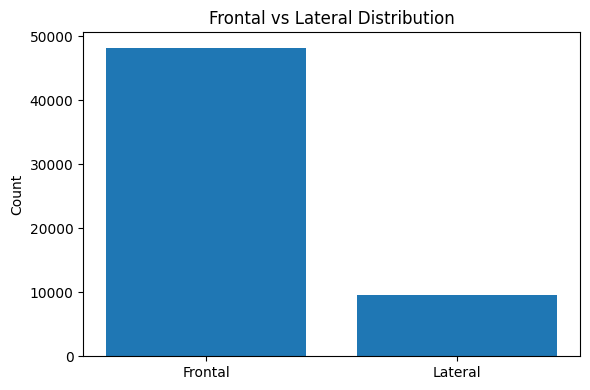

In [10]:
plt.figure(figsize=(6, 4))
plt.bar(frontal_lateral_counts.keys(), frontal_lateral_counts.values())
plt.ylabel('Count')
plt.title('Frontal vs Lateral Distribution')
plt.tight_layout()

In [11]:
merged_df = merged_df[merged_df['frontal_lateral'] == 'Frontal']  # 过滤
len(merged_df)

48232

In [12]:
frontal_lateral_counts = merged_df["frontal_lateral"].value_counts().to_dict()
frontal_lateral_nan_num = merged_df["frontal_lateral"].isna().sum()
frontal_lateral_null_num = merged_df["frontal_lateral"].isnull().sum()
print(frontal_lateral_counts)
print(frontal_lateral_nan_num)
print(frontal_lateral_null_num)
# 没有NaN值, 没有Null值

{'Frontal': 48232}
0
0


In [13]:
merged_df.iloc[-1]

path_to_image                       train/patient59696/study1/view1_frontal.jpg
Enlarged Cardiomediastinum                                                  NaN
Cardiomegaly                                                                NaN
Lung Opacity                                                                NaN
Lung Lesion                                                                 NaN
Edema                                                                       NaN
Consolidation                                                               NaN
Pneumonia                                                                   NaN
Atelectasis                                                                 NaN
Pneumothorax                                                                NaN
Pleural Effusion                                                            NaN
Pleural Other                                                               NaN
Fracture                                

### 检查 findings 和 impression 是否有效

In [14]:
# 定义检验函数
def is_valid_text(text):
    if pd.isna(text):
        return False
    if not isinstance(text, str):
        return False
    return len(text.split()) >= 2

In [15]:
valid_findings = merged_df['section_findings'].apply(is_valid_text).sum()
print(f"包含有效findings的元素数量: {valid_findings}")

valid_impression = merged_df['section_impression'].apply(is_valid_text).sum()
print(f"包含有效impression的元素数量: {valid_impression}")

包含有效findings的元素数量: 48232
包含有效impression的元素数量: 48205


In [16]:
# # 把 findings 为空且长度小于2的数据去掉
merged_df = merged_df[merged_df['section_impression'].apply(lambda x: isinstance(x, str) and len(x.split()) >= 2)]

#### 还剩 48205 个数据

In [17]:
len(merged_df)

48205

In [18]:
# 统计path_to_image以"jpg"结尾的元素数量
jpg_count = merged_df['path_to_image'].apply(
    lambda x: isinstance(x, str) and x.lower().endswith('.jpg')
).sum()

# 输出结果
print(f"数据集总数: {len(merged_df)}")
print(f"以'.jpg'结尾的path_to_image数量: {jpg_count}")

数据集总数: 48205
以'.jpg'结尾的path_to_image数量: 48205


In [19]:
def change_extension(path):
    """将.jpg扩展名改为.png，保留其他路径不变"""
    if not isinstance(path, str):
        return path  # 非字符串值保持不变
    if path.lower().endswith('.jpg'):
        return os.path.splitext(path)[0] + '.png'
    return path

# 应用更改到path_to_image列
merged_df['path_to_image'] = merged_df['path_to_image'].apply(change_extension)

In [20]:
jpg_count = merged_df['path_to_image'].apply(
    lambda x: isinstance(x, str) and x.lower().endswith('.jpg')
).sum()

png_count = merged_df['path_to_image'].apply(
    lambda x: isinstance(x, str) and x.lower().endswith('.png')
).sum()

print(f"数据集总数: {len(merged_df)}")
print(f"以'.jpg'结尾的path_to_image数量: {jpg_count}")
print(f"以'.png'结尾的path_to_image数量: {png_count}")

数据集总数: 48205
以'.jpg'结尾的path_to_image数量: 0
以'.png'结尾的path_to_image数量: 48205


In [21]:
merged_df.iloc[-1]
# 改完之后的结构

path_to_image                       train/patient59696/study1/view1_frontal.png
Enlarged Cardiomediastinum                                                  NaN
Cardiomegaly                                                                NaN
Lung Opacity                                                                NaN
Lung Lesion                                                                 NaN
Edema                                                                       NaN
Consolidation                                                               NaN
Pneumonia                                                                   NaN
Atelectasis                                                                 NaN
Pneumothorax                                                                NaN
Pleural Effusion                                                            NaN
Pleural Other                                                               NaN
Fracture                                

### 全阴性占比

In [22]:
no_finding_counts = merged_df["No Finding"].value_counts().to_dict()
no_finding_nan_num = merged_df["No Finding"].isna().sum()
no_finding_null_num = merged_df["No Finding"].isnull().sum()
print(no_finding_counts)
print(no_finding_nan_num)
print(no_finding_null_num)
positive_negative_counts = {"positive": int(no_finding_null_num), "negetive": no_finding_counts[1.0]}
print(positive_negative_counts)
print(f"全阴性占比：{no_finding_counts[1.0] / len(merged_df) * 100 :.2f}%")

{1.0: 2848}
45357
45357
{'positive': 45357, 'negetive': 2848}
全阴性占比：5.91%


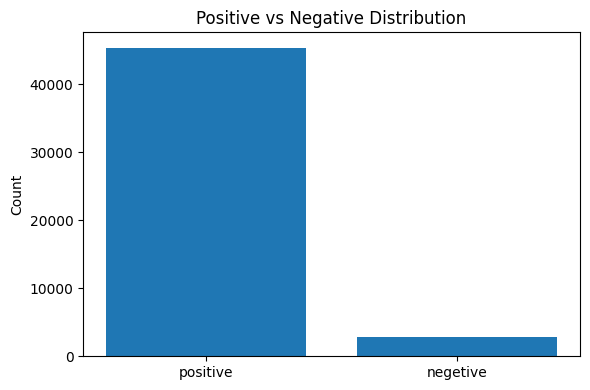

In [23]:
plt.figure(figsize=(6, 4))
plt.bar(positive_negative_counts.keys(), positive_negative_counts.values())
plt.ylabel('Count')
plt.title('Positive vs Negative Distribution')
plt.tight_layout()

In [24]:
merged_df.iloc[0].to_dict()

{'path_to_image': 'train/patient04528/study1/view1_frontal.png',
 'Enlarged Cardiomediastinum': -1.0,
 'Cardiomegaly': nan,
 'Lung Opacity': 1.0,
 'Lung Lesion': nan,
 'Edema': nan,
 'Consolidation': -1.0,
 'Pneumonia': nan,
 'Atelectasis': -1.0,
 'Pneumothorax': nan,
 'Pleural Effusion': nan,
 'Pleural Other': nan,
 'Fracture': nan,
 'Support Devices': 1.0,
 'No Finding': nan,
 'path_to_dcm': 'train/patient04528/study1/view1_frontal.dcm',
 'frontal_lateral': 'Frontal',
 'ap_pa': 'PA',
 'deid_patient_id': 'patient04528',
 'patient_report_date_order': 2,
 'report': 'NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 11-28-2005\n \nCLINICAL HISTORY: 61 years of age, Female, R o infiltarate..AML \n(acute myeloblastic leukemia)\n \nCOMPARISON: 11/28/2005\n \nPROCEDURE COMMENTS: Two views of the chest. \n \nFINDINGS:\n \nUnchanged position of the left upper extremity PICC line. Again seen \nare surgical clips projecting over the right hemithorax. The \ncardiomediastinal silhouette is stable

### 去掉没用的标签

In [25]:
desired_columns = [
    'path_to_image',
    'No Finding',
    'frontal_lateral',
    'ap_pa',
    'deid_patient_id',
    'patient_report_date_order',
    'section_narrative',
    'section_clinical_history',
    'section_history',
    'section_comparison',
    'section_procedure_comments',
    'section_findings',
    'section_impression',
    'No Finding',
    'frontal_lateral',
    'age',
    'sex',
    'split'
]

filtered_df = merged_df[desired_columns]

In [26]:
filtered_df.iloc[0].to_dict()

{'path_to_image': 'train/patient04528/study1/view1_frontal.png',
 'No Finding': nan,
 'frontal_lateral': 'Frontal',
 'ap_pa': 'PA',
 'deid_patient_id': 'patient04528',
 'patient_report_date_order': 2,
 'section_narrative': '\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 11-28-2005\n \n',
 'section_clinical_history': ' 61 years of age, Female, R o infiltarate..AML \n(acute myeloblastic leukemia)\n \n',
 'section_history': nan,
 'section_comparison': ' 11/28/2005\n \n',
 'section_procedure_comments': ' Two views of the chest. \n \n',
 'section_findings': '\n \nUnchanged position of the left upper extremity PICC line. Again seen \nare surgical clips projecting over the right hemithorax. The \ncardiomediastinal silhouette is stable in appearance. Increased \nstranding opacities are noted in the left retrocardiac region. Subtle \nstranding opacities in the right upper lung zone are unchanged.. \nThere are no pleural or significant bony abnormalities. Absence of \nthe right breast shadow compatibl

### 打包到json

In [27]:
desktop_path = "D:\\Documents\\CheXpert_Plus"
filename = os.path.join(desktop_path, "chexpert_dataset_filtered.json")

In [28]:
result = []

for idx in range(len(filtered_df)):
    item = filtered_df.iloc[idx].to_dict()
    result.append(item)

In [29]:
with open(filename, 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

In [43]:
# 检查


with open("chexpert_dataset_filtered.json", 'r', encoding='utf-8') as f:
      dataset = json.load(f)
data = dataset[0:]
data[0]

{'path_to_image': 'train/patient04528/study1/view1_frontal.png',
 'No Finding': nan,
 'frontal_lateral': 'Frontal',
 'ap_pa': 'PA',
 'deid_patient_id': 'patient04528',
 'patient_report_date_order': 2,
 'section_narrative': '\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 11-28-2005\n \n',
 'section_clinical_history': ' 61 years of age, Female, R o infiltarate..AML \n(acute myeloblastic leukemia)\n \n',
 'section_history': nan,
 'section_comparison': ' 11/28/2005\n \n',
 'section_procedure_comments': ' Two views of the chest. \n \n',
 'section_findings': '\n \nUnchanged position of the left upper extremity PICC line. Again seen \nare surgical clips projecting over the right hemithorax. The \ncardiomediastinal silhouette is stable in appearance. Increased \nstranding opacities are noted in the left retrocardiac region. Subtle \nstranding opacities in the right upper lung zone are unchanged.. \nThere are no pleural or significant bony abnormalities. Absence of \nthe right breast shadow compatibl

In [44]:
len(data)

48205

### 疾病分布

In [32]:
merged_df.iloc[0].to_dict() # 使用“去掉没用标签”之前的dataframe

{'path_to_image': 'train/patient04528/study1/view1_frontal.png',
 'Enlarged Cardiomediastinum': -1.0,
 'Cardiomegaly': nan,
 'Lung Opacity': 1.0,
 'Lung Lesion': nan,
 'Edema': nan,
 'Consolidation': -1.0,
 'Pneumonia': nan,
 'Atelectasis': -1.0,
 'Pneumothorax': nan,
 'Pleural Effusion': nan,
 'Pleural Other': nan,
 'Fracture': nan,
 'Support Devices': 1.0,
 'No Finding': nan,
 'path_to_dcm': 'train/patient04528/study1/view1_frontal.dcm',
 'frontal_lateral': 'Frontal',
 'ap_pa': 'PA',
 'deid_patient_id': 'patient04528',
 'patient_report_date_order': 2,
 'report': 'NARRATIVE:\nRADIOGRAPHIC EXAMINATION OF THE CHEST: 11-28-2005\n \nCLINICAL HISTORY: 61 years of age, Female, R o infiltarate..AML \n(acute myeloblastic leukemia)\n \nCOMPARISON: 11/28/2005\n \nPROCEDURE COMMENTS: Two views of the chest. \n \nFINDINGS:\n \nUnchanged position of the left upper extremity PICC line. Again seen \nare surgical clips projecting over the right hemithorax. The \ncardiomediastinal silhouette is stable

### 选出疾病

In [33]:
disease_column = [
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices',
    'No Finding'
]

disease_df = merged_df[disease_column]

In [34]:
disease_df.iloc[4]

Enlarged Cardiomediastinum    0.0
Cardiomegaly                  NaN
Lung Opacity                  NaN
Lung Lesion                   NaN
Edema                        -1.0
Consolidation                 0.0
Pneumonia                     NaN
Atelectasis                   NaN
Pneumothorax                  NaN
Pleural Effusion              1.0
Pleural Other                 NaN
Fracture                      NaN
Support Devices               1.0
No Finding                    NaN
Name: 52, dtype: float64

### 换标签，增加可读性

In [35]:
def map_labels(value):
    if value == 1.0:
        return 'positive'
    elif value == 0.0:
        return 'negative'
    elif value == -1.0:
        return 'uncertain'
    else:
        return 'not mentioned'

In [36]:
categorical_df = disease_df.map(map_labels)

In [37]:
categorical_df.iloc[4]

Enlarged Cardiomediastinum         negative
Cardiomegaly                  not mentioned
Lung Opacity                  not mentioned
Lung Lesion                   not mentioned
Edema                             uncertain
Consolidation                      negative
Pneumonia                     not mentioned
Atelectasis                   not mentioned
Pneumothorax                  not mentioned
Pleural Effusion                   positive
Pleural Other                 not mentioned
Fracture                      not mentioned
Support Devices                    positive
No Finding                    not mentioned
Name: 52, dtype: object

### 统计

In [38]:
results = []
total_patients = len(categorical_df)
total_patients

48205

In [39]:
for disease in categorical_df.columns:
    counts = categorical_df[disease].value_counts()
    
    # 获取四种状态的数量
    positive = counts.get('positive', 0)
    negative = counts.get('negative', 0)
    uncertain = counts.get('uncertain', 0)
    not_mentioned = counts.get('not mentioned', 0) + counts.get(None, 0)  # 处理可能的None值
    
    # 计算百分比
    positive_pct = (positive / total_patients) * 100
    negative_pct = (negative / total_patients) * 100
    uncertain_pct = (uncertain / total_patients) * 100
    not_mentioned_pct = (not_mentioned / total_patients) * 100
    
    # 添加到结果列表
    results.append({
        'Pathology': disease,
        'Positive(%)': f"{positive:,} ({positive_pct:.2f})",
        'Uncertain(%)': f"{uncertain:,} ({uncertain_pct:.2f})",
        'Negative(%)': f"{negative:,} ({negative_pct:.2f})",
        'Not Mentioned(%)': f"{not_mentioned:,} ({not_mentioned_pct:.2f})"
    })

In [40]:
result_df = pd.DataFrame(results)

# 3. 按指定顺序排列列
result_df = result_df[['Pathology', 'Positive(%)', 'Uncertain(%)', 'Negative(%)', 'Not Mentioned(%)']]


In [41]:
result_df

,Pathology,Positive(%),Uncertain(%),Negative(%),Not Mentioned(%)
0,Enlarged Cardiomediastinum,"2,005 (4.16)","4,130 (8.57)","7,242 (15.02)","34,828 (72.25)"
1,Cardiomegaly,"7,858 (16.30)","1,474 (3.06)","5,684 (11.79)","33,189 (68.85)"
2,Lung Opacity,"23,552 (48.86)",119 (0.25),"1,471 (3.05)","23,063 (47.84)"
3,Lung Lesion,"2,823 (5.86)",284 (0.59),306 (0.63),"44,792 (92.92)"
4,Edema,"11,553 (23.97)","2,804 (5.82)","5,090 (10.56)","28,758 (59.66)"
5,Consolidation,"3,057 (6.34)","6,041 (12.53)","7,354 (15.26)","31,753 (65.87)"
6,Pneumonia,"1,304 (2.71)","4,949 (10.27)","1,003 (2.08)","40,949 (84.95)"
7,Atelectasis,"8,171 (16.95)","7,587 (15.74)",160 (0.33),"32,287 (66.98)"
8,Pneumothorax,"4,088 (8.48)",626 (1.30),"14,518 (30.12)","28,973 (60.10)"
9,Pleural Effusion,"19,745 (40.96)","1,633 (3.39)","9,704 (20.13)","17,123 (35.52)"


### 画表

In [42]:
print(result_df.to_string(index=False))

                 Pathology    Positive(%)  Uncertain(%)    Negative(%) Not Mentioned(%)
Enlarged Cardiomediastinum   2,005 (4.16)  4,130 (8.57)  7,242 (15.02)   34,828 (72.25)
              Cardiomegaly  7,858 (16.30)  1,474 (3.06)  5,684 (11.79)   33,189 (68.85)
              Lung Opacity 23,552 (48.86)    119 (0.25)   1,471 (3.05)   23,063 (47.84)
               Lung Lesion   2,823 (5.86)    284 (0.59)     306 (0.63)   44,792 (92.92)
                     Edema 11,553 (23.97)  2,804 (5.82)  5,090 (10.56)   28,758 (59.66)
             Consolidation   3,057 (6.34) 6,041 (12.53)  7,354 (15.26)   31,753 (65.87)
                 Pneumonia   1,304 (2.71) 4,949 (10.27)   1,003 (2.08)   40,949 (84.95)
               Atelectasis  8,171 (16.95) 7,587 (15.74)     160 (0.33)   32,287 (66.98)
              Pneumothorax   4,088 (8.48)    626 (1.30) 14,518 (30.12)   28,973 (60.10)
          Pleural Effusion 19,745 (40.96)  1,633 (3.39)  9,704 (20.13)   17,123 (35.52)
             Pleural Other   1,2

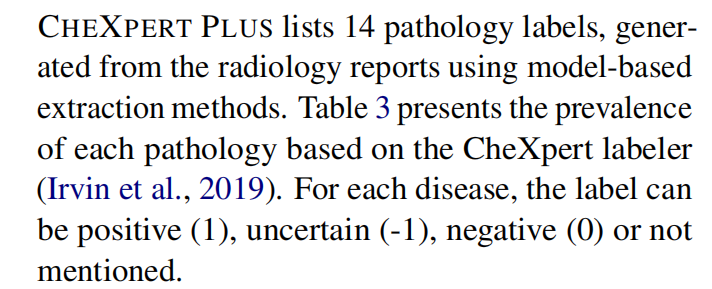

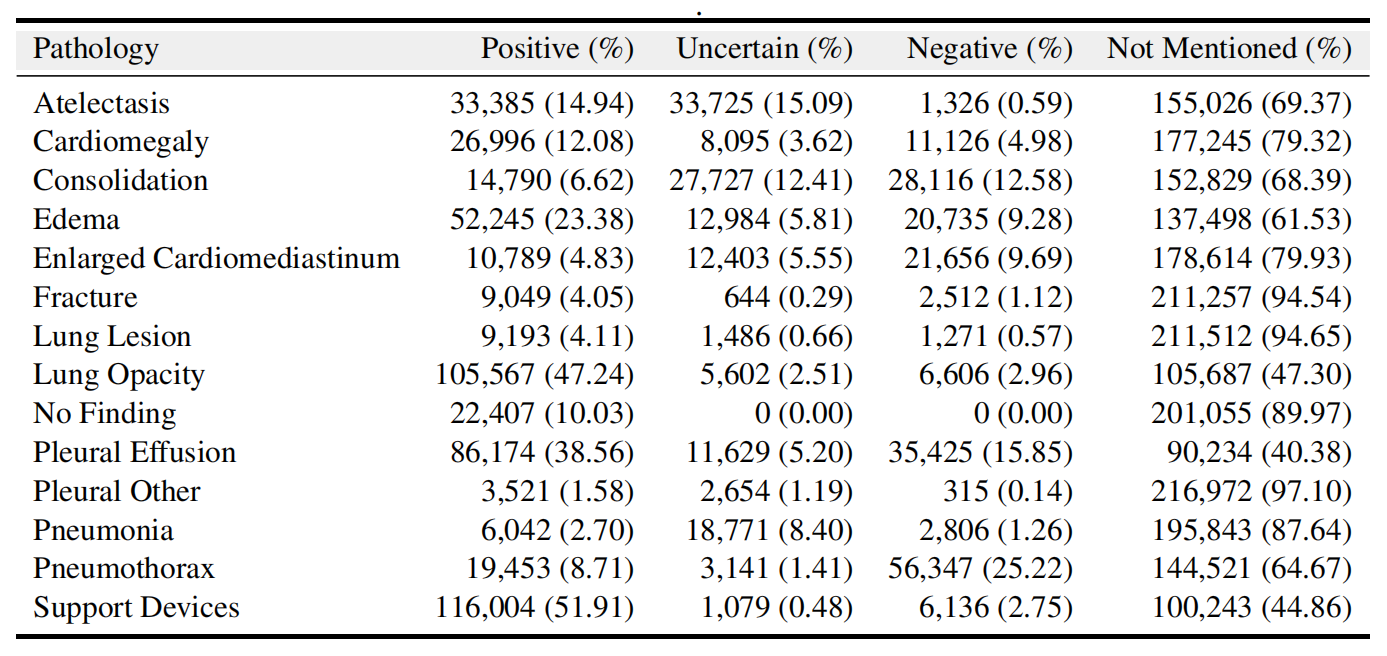